# Using python to mimic FORTRAN CJ code

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time, multiprocessing, os, sys, cProfile, pstats, io
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from matplotlib.ticker import LogLocator
from functools import lru_cache
from joblib import Parallel, delayed


# Reading the input file

In [3]:
filepath = '/Users/AbSir/Desktop/cj22/CJ-code/fitpack/nucl/phi.wbarel_AV18'
gamma_list = []
y_list = []
f2_list = []
f0_list = []
print(f"Number of cores available: {multiprocessing.cpu_count()}")
with open(filepath, 'r') as file:
    for line in file:
        try:
            columns = [float(col) for col in line.split()]
            if len(columns) == 8:
                gamma_list.append(columns[0])
                y_list.append(columns[1])
                f2_list.append(columns[6])
                f0_list.append(columns[2])
        except:
            continue
gamma_array = np.array(gamma_list)
y_array = np.array(y_list)
f2_array = np.array(f2_list)
f0_array = np.array(f0_list)

Number of cores available: 8


# The faster integration

In [4]:
results_cache = {}  # Dictionary to cache (avoid multiple computation)

def get_interpolator(gamma_fixed):
    # Check if the interpolator is already computed
    if gamma_fixed not in results_cache:
        mask = gamma_array == gamma_fixed
        y_filtered = y_array[mask]
        f0_filtered = f0_array[mask]
        results_cache[gamma_fixed] = interp1d(y_filtered, f0_filtered, kind='linear', fill_value='extrapolate')
    return results_cache[gamma_fixed]

def phi_int2d_fixed_gamma(y_D_grid, gamma_fixed):
    interpolator = get_interpolator(gamma_fixed)
    return interpolator(y_D_grid)

def f2nxn_function(x):
    x_N = 2 * x # Convert from x_D to x_N
    return 4 * x_N**0.7 * (1 - x_N)**3.5 * (1 + 4 * x_N) + 0.15 * x_N**(-0.4) * (1 - x_N)**9 * (1 + 16 * x_N)

def f2_function(x, y_D):
    k = x / y_D
    return 4 * k**0.7 * (1 - k)**3.5 * (1 + 4 * k) + 0.15 * k**(-0.4) * (1 - k)**9 * (1 + 16 * k)

def integrand(y_D_grid, x):
    f0 = phi_int2d_fixed_gamma(y_D_grid, gamma_fixed)
    f2 = f2_function(x, y_D_grid)
    return f2 * f0

def integrate_f2_f0(x_val):
    f2dxd, error = quad(integrand, x_val, 1, args=(x_val,), points = [0.5])
    return f2dxd, error

# Importance sampling grid
y_D_grid = np.concatenate([np.linspace(0, 0.4, 200), np.linspace(0.4, 0.6, 300), np.linspace(0.6, 1, 200)])

gamma_fixed = 1.0
x = np.linspace(0, 1, 5000)  # x_D values

# Parallel computation. n_jobs=-1 means using all available cores. The delayed function is a way to specify a computation without actually running it.
# This allows the Parallel object to run the computation in parallel.
results = Parallel(n_jobs=-1)(delayed(integrate_f2_f0)(x_val) for x_val in x)
integral_result_list, error_list = map(np.array, zip(*results))
simple_f2_list = f2nxn_function(x)
ratio = integral_result_list / simple_f2_list

/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_89721/3391051529.py:22: RuntimeWarning: divide by zero encountered in scalar power
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_89721/3391051529.py:27: RuntimeWarning: invalid value encountered in multiply
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_89721/3391051529.py:30: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_89721/3391051529.py:30: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_89721/3391051529.py:30: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised

In [5]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [6]:
# Cache to store interpolators and avoid redundant computation
results_cache = {}  

def get_interpolator(gamma_fixed):
    """Retrieve or create an interpolator for the specified gamma value."""
    if gamma_fixed not in results_cache:
        mask = gamma_array == gamma_fixed
        y_filtered = y_array[mask]
        f0_filtered = f0_array[mask]
        # Cache the interpolator
        results_cache[gamma_fixed] = interp1d(y_filtered, f0_filtered, kind='linear', fill_value='extrapolate')
    return results_cache[gamma_fixed]

def phi_int2d_fixed_gamma(y_D_grid, gamma_fixed):
    """Calculate interpolated values over a grid of y_D values for a fixed gamma."""
    interpolator = get_interpolator(gamma_fixed)
    return interpolator(y_D_grid)

def f2nxn_function(x):
    """Function to process x values, converting from x_D to x_N and calculating the formula."""
    x_N = 2 * x  # Convert from x_D to x_N
    return 4 * x_N**0.7 * (1 - x_N)**3.5 * (1 + 4 * x_N) + 0.15 * x_N**(-0.4) * (1 - x_N)**9 * (1 + 16 * x_N)

def f2_function(x, y_D):
    """Calculate the f2 function based on x and y_D."""
    k = x / y_D
    return 4 * k**0.7 * (1 - k)**3.5 * (1 + 4 * k) + 0.15 * k**(-0.4) * (1 - k)**9 * (1 + 16 * k)

def integrand(y_D_grid, x):
    """Integrand function combining f0 and f2 computations."""
    f0 = phi_int2d_fixed_gamma(y_D_grid, gamma_fixed)
    f2 = f2_function(x, y_D_grid)
    return f2 * f0

def integrate_f2_f0(x_val):
    """Perform numerical integration for the provided x_val."""
    f2dxd, error = quad(integrand, x_val, 1, args=(x_val,), points=[0.5])
    return f2dxd, error

# Example usage and setup
gamma_fixed = 1.0
x = np.linspace(0, 1, 5000)  # x_D values

def main():
    """Main function to run parallel computation of integrals."""
    # Parallel computation using all available cores
    results = Parallel(n_jobs=-1)(delayed(integrate_f2_f0)(x_val) for x_val in x)
    integral_result_list, error_list = map(np.array, zip(*results))
    simple_f2_list = f2nxn_function(x)
    ratio = integral_result_list / simple_f2_list

# Example profiling, if needed
cProfile.run('main()', 'profiling_stats')
p = pstats.Stats('profiling_stats')
p.sort_stats('time').print_stats(10)


/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_89721/740184807.py:27: RuntimeWarning: divide by zero encountered in scalar power
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_89721/740184807.py:33: RuntimeWarning: invalid value encountered in multiply
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_89721/740184807.py:37: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_89721/740184807.py:37: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the s

Wed May  1 19:27:22 2024    profiling_stats

         19329 function calls (19325 primitive calls) in 10.070 seconds

   Ordered by: internal time
   List reduced from 214 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      803   10.034    0.012   10.034    0.012 {built-in method time.sleep}
     4965    0.020    0.000   10.061    0.002 /Users/AbSir/anaconda3/envs/root_env/lib/python3.10/site-packages/joblib/parallel.py:1746(_retrieve)
     5002    0.004    0.000   10.066    0.002 /Users/AbSir/anaconda3/envs/root_env/lib/python3.10/site-packages/joblib/parallel.py:1638(_get_outputs)
     1350    0.003    0.000    0.003    0.000 /Users/AbSir/anaconda3/envs/root_env/lib/python3.10/site-packages/joblib/parallel.py:1719(_wait_retrieval)
      564    0.001    0.000    0.001    0.000 /Users/AbSir/anaconda3/envs/root_env/lib/python3.10/site-packages/joblib/parallel.py:760(_return_or_raise)
        1    0.001    0.001   10.068   10.068 /

/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_89721/740184807.py:22: RuntimeWarning: invalid value encountered in power
  return 4 * x_N**0.7 * (1 - x_N)**3.5 * (1 + 4 * x_N) + 0.15 * x_N**(-0.4) * (1 - x_N)**9 * (1 + 16 * x_N)
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_89721/740184807.py:22: RuntimeWarning: divide by zero encountered in power
  return 4 * x_N**0.7 * (1 - x_N)**3.5 * (1 + 4 * x_N) + 0.15 * x_N**(-0.4) * (1 - x_N)**9 * (1 + 16 * x_N)


In [9]:
%lprun -f main main()

/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_89721/740184807.py:27: RuntimeWarning: divide by zero encountered in scalar power
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_89721/740184807.py:33: RuntimeWarning: invalid value encountered in multiply
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_89721/740184807.py:37: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_89721/740184807.py:37: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the s

Timer unit: 1e-09 s

Total time: 9.89043 s
File: /var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_89721/740184807.py
Function: main at line 44

Line #      Hits         Time  Per Hit   % Time  Line Contents
    44                                           def main():
    45                                               """Main function to run parallel computation of integrals."""
    46                                               # Parallel computation using all available cores
    47         1 9889144000.0    1e+10    100.0      results = Parallel(n_jobs=-1)(delayed(integrate_f2_f0)(x_val) for x_val in x)
    48         1     650000.0 650000.0      0.0      integral_result_list, error_list = map(np.array, zip(*results))
    49         1     633000.0 633000.0      0.0      simple_f2_list = f2nxn_function(x)
    50         1       3000.0   3000.0      0.0      ratio = integral_result_list / simple_f2_list

# Plot it

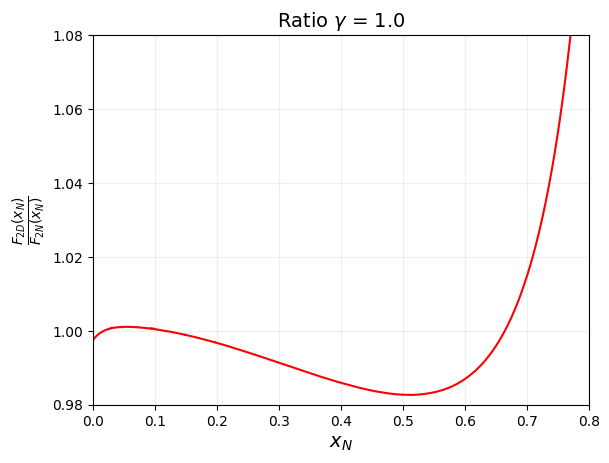

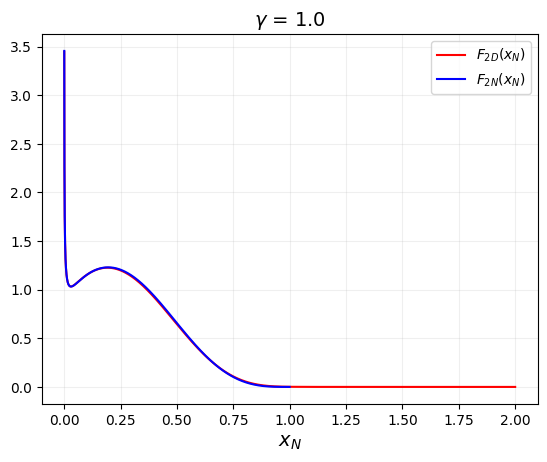

In [7]:
fig3, ax3 = plt.subplots()
x_N = x * 2
ax3.plot(x_N, ratio, 'r')
ax3.grid(alpha = 0.2)
ax3.set_xlabel(r'$x_N$', fontsize = 14)
ax3.set_ylabel(r'$\frac{F_{2D}(x_N)}{F_{2N}(x_N)}$', fontsize = 14)
ax3.set_title(fr'Ratio $\gamma$ = {gamma_fixed}', fontsize = 14)
ax3.set_xlim(0.0, 0.8)
ax3.set_ylim(0.98, 1.08)
# ax3.set_yscale('log')
fig3.savefig(f'plots/ratio_{time.time():.0f}.pdf')

fig2, ax2 = plt.subplots()
# ax2.plot(x, integral_result_list, 'r', label = r'$\int_{x_D}^1 dy_D f_0(y_D;\gamma)F_{2N}(x_D/y_D)$')
ax2.plot(x_N, integral_result_list, 'r', label = r'$F_{2D}(x_N)$')
ax2.plot(x_N, simple_f2_list, 'b', label = r'$F_{2N}(x_N)$')
ax2.grid(alpha = 0.2)
ax2.set_xlabel(r'$x_N$', fontsize = 14)
ax2.set_title(fr'$\gamma$ = {gamma_fixed}', fontsize = 14)
ax2.legend()
# fig2.savefig(f'plots/integral_{time.time():.0f}.pdf')

(1e-10, 0.001)

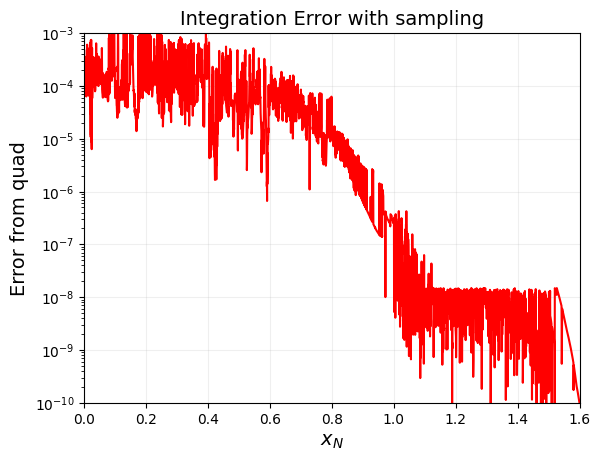

In [8]:
fig, ax = plt.subplots()
x_N = 2 * x
ax.plot(x_N, error_list, 'r')
ax.grid(alpha = 0.2)
ax.set_xlabel(r'$x_N$', fontsize = 14)
ax.set_ylabel('Error from quad', fontsize = 14)
ax.set_title('Integration Error with sampling', fontsize = 14)
ax.set_yscale('log')
ax.set_xlim(0, 1.6)
ax.set_ylim(1e-10, 1e-3)
# plt.savefig(f'plots/error_{time.time():.0f}.pdf')